In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
dr2period=22/12 # in years
edr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

In [4]:
# setting epoch to dr3 (2016.0) - also accepts dr1, dr2 and any BJD
astromet.setEpoch('dr3')

In [118]:
# times when system is observed [years] relative to start of Gaia's observations (2456863.94 BJD)
ts=np.sort(edr3Period*(-0.5+np.random.rand(64)))

# an object wich holds all the necessary parameters to find the astrometric path
params=astromet.params()

# For this example we'll generate a random binary system

# center of mass parameters
params.RA=360*np.random.rand()
params.Dec=90*(-1+2*np.random.rand())
print('RA and Dec [degrees]: \n',params.RA,params.Dec)
params.pmRA=10*np.random.randn()
params.pmDec=10*np.random.randn()
print('Proper motion in RA and Dec [mas/yr]: \n',params.pmRA,params.pmDec)
params.pllx=1+9*np.random.rand()
print('Parallax [mas]: \n',params.pllx)

# binary parameters
params.M=10*np.random.rand()**2
print('Mass of brightest source [mSun]: \n',params.M)
params.a=5*np.random.rand()
print('Semi-major axis [AU]: \n',params.a)
params.e=np.random.rand()
print('Eccentricity [dimensionless]: \n',params.e)
params.q=10*(np.random.rand()**4)
params.l=np.random.rand()
print('Light (l<1) and mass (q) ratios of binary [dimensionless]: \n',params.l,params.q)
params.vPhi=2*np.pi*np.random.rand()
params.vTheta=np.pi*np.random.rand()
print('On-sky projection angles (vPhi and vTheta) of binary [radians]: \n',params.vPhi,params.vTheta)
params.vOmega=2*np.pi*np.random.rand()
print('On-sky orientation angle of binary [radians]: \n',params.vOmega)
params.tPeri=astromet.period(params)*np.random.rand()
print('Time of first binary periapse [years]: \n',params.tPeri)

print('\nPeriod [years]: \n',astromet.period(params))

RA and Dec [degrees]: 
 3.3923274496515132 18.01847436366774
Proper motion in RA and Dec [mas/yr]: 
 12.406151385153406 9.740849671200378
Parallax [mas]: 
 6.287249498711859
Mass of brightest source [mSun]: 
 0.03409297757176923
Semi-major axis [AU]: 
 0.28129947576703396
Eccentricity [dimensionless]: 
 0.2961977918198907
Light (l<1) and mass (q) ratios of binary [dimensionless]: 
 0.6187311468409828 4.2736400425482755
On-sky projection angles (vPhi and vTheta) of binary [radians]: 
 2.412404105334172 0.886523811076727
On-sky orientation angle of binary [radians]: 
 1.5434042264677876
Time of first binary periapse [years]: 
 0.27709731922881103

Period [years]: 
 0.35097026816505783


In [119]:
# on sky paths [degrees]
ras,decs=astromet.path(ts,params)

# adding random (1/3 mas) error
astError=1/3
ras=ras+astError*mas*np.random.randn(ras.size)
decs=decs+astError*mas*np.random.randn(ras.size)

# fitting for offset from first obs (delta RA_0 & delta Dec_0), proper motion and parralax
fitParams,fitCovariance=astromet.fit(ts,ras,decs,astError=astError)
print('original parameters [mas]: \n',0,0,params.pmRA,params.pmDec,params.pllx)
print('derived parameters [mas]: \n',fitParams)
# extracting single parameter errors from covariance matrix
fitErrors=np.sqrt(np.diagonal(fitCovariance))/astError
print('derived parameter error [mas]: \n',fitErrors)
# note that parameters may not agree within error bars due to binary contribution

print('\ncovariance matrix [mas**2]: \n',fitCovariance)


## mistake somewhere in this calibration
## ruwe is sqrt magnitude of covariance matrix normalised by error
#uwe=np.sqrt(np.linalg.norm(fitCovariance))/astError
#print('UWE [dimensionless]: \n',uwe)



original parameters [mas]: 
 0 0 12.406151385153406 9.740849671200378 6.287249498711859
derived parameters [mas]: 
 [ 2.97860947  1.35266151 12.44981073  9.64571438  6.25294236]
derived parameter error [mas]: 
 [0.13186771 0.13036768 0.16179774 0.16263319 0.17885663]

covariance matrix [mas**2]: 
 [[1.93212137e-03 2.02438352e-05 6.62156316e-04 4.20523749e-05
  4.28436494e-04]
 [2.02438352e-05 1.88841471e-03 5.72275927e-06 6.64042073e-04
  1.67947653e-04]
 [6.62156316e-04 5.72275927e-06 2.90872302e-03 1.18878471e-05
  1.21115337e-04]
 [4.20523749e-05 6.64042073e-04 1.18878471e-05 2.93883937e-03
  3.48876464e-04]
 [4.28436494e-04 1.67947653e-04 1.21115337e-04 3.48876464e-04
  3.55441065e-03]]


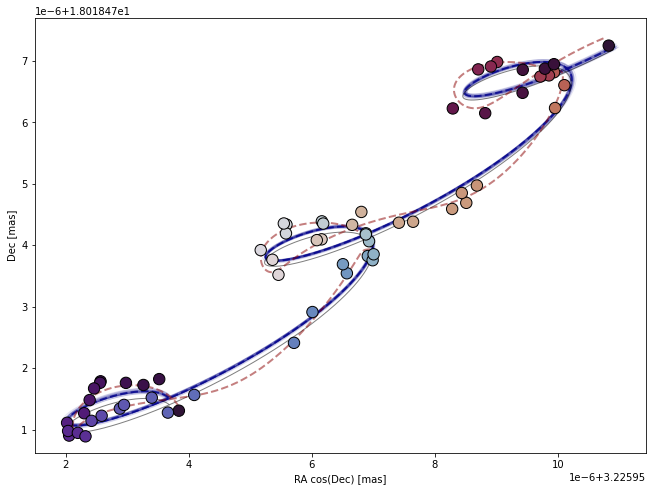

In [120]:
# plotting on sky motion
qFig=plt.figure(figsize=(12,8))
qPl=plt.gca() # defining matplotlib axis object on which to plot

cs=mpl.cm.twilight_shifted(np.interp(ts,[ts[0],ts[-1]],[0,1])) # optional, but I like to color by time

# plotting the datapoints (ideally as error ellipses -
# if that fails comment out the for loop and use the simpler scatter plot instead)
for i in range(ras.size):
    ell = mpl.patches.Ellipse(xy=(ras[i]*np.cos(decs[i]*np.pi/180), decs[i]),
                  width=2*astError*mas, height=2*astError*mas,
                  angle=0)
    ell.set_facecolor(cs[i])
    ell.set_edgecolor('k')
    qPl.add_artist(ell)
#qPl.scatter(ras*np.cos(decs*np.pi/180),decs,s=50,c=cs,zorder=2,edgecolors='k',lw=1)

# uniformly sampled times for plotting true paths
tUniform=np.linspace(ts[0],ts[-1],1000)

# optional - adding the centre of mass motion (black) for reference
comRas,comDecs=astromet.path(tUniform,params,comOnly=True)
qPl.plot(comRas*np.cos(comDecs*np.pi/180),comDecs,lw=1,c='k',alpha=0.5,zorder=1)

# optional - adding the centre of mass motion (red) for reference
trueRas,trueDecs=astromet.path(tUniform,params)
qPl.plot(trueRas*np.cos(trueDecs*np.pi/180),trueDecs,lw=2,c='darkred',alpha=0.5,zorder=1,ls='--')

# optional - adding fitted motion (blue)
for i in range(32):
    sampleParams = np.random.multivariate_normal(fitParams, fitCovariance)
    
    fitPs=astromet.params()
    fitPs.RA=np.median(ras)+mas*sampleParams[0]
    fitPs.Dec=np.median(decs)+mas*sampleParams[1]
    fitPs.pmRA=sampleParams[2]
    fitPs.pmDec=sampleParams[3]
    fitPs.pllx=sampleParams[4]
    bestRas,bestDecs=astromet.path(tUniform,fitPs,comOnly=True)
    qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=1,c='darkblue',alpha=0.1,zorder=0)
fitPs=astromet.params()
fitPs.RA=np.median(ras)+mas*fitParams[0]
fitPs.Dec=np.median(decs)+mas*fitParams[1]
fitPs.pmRA=fitParams[2]
fitPs.pmDec=fitParams[3]
fitPs.pllx=fitParams[4]
bestRas,bestDecs=astromet.path(tUniform,fitPs,comOnly=True)
qPl.plot(bestRas*np.cos(bestDecs*np.pi/180),bestDecs,lw=2,c='darkblue',alpha=0.8,zorder=0,ls='--')

# adding initial position and proper motion as arrow
#qPl.arrow(np.median(ras*np.cos(decs*np.pi/180)),np.median(decs),mas*params.pmRA,mas*params.pmDec,color='k',alpha=0.5)

qPl.set_xlabel('RA cos(Dec) [mas]')
qPl.set_ylabel('Dec [mas]')
qPl.set_aspect('equal')

plt.show()